In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat


In [2]:
import matplotlib.pyplot as plt
import numpy as np          
from os.path import dirname, join as pjoin
import scipy.io as sio
import torch

from math import cos,sin

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [3]:
mat_fname = "/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat"
mat_contents = sio.loadmat(mat_fname, spmatrix=False)

In [73]:
mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed May 21 11:26:03 2025',
 '__version__': '1.0',
 '__globals__': [],
 'F': array([[ 2.52212399,  0.25257685, -0.17632473, ..., -0.93974505,
          0.73219754, -0.21731491],
        [ 2.52212399,  0.31377339, -0.20708152, ..., -0.93195276,
          1.1898421 ,  0.08906574],
        [ 2.52212399,  0.19456473, -0.22254519, ..., -0.884662  ,
          0.73310509,  0.59302917],
        ...,
        [ 2.52212399,  0.35849052, -0.10983818, ..., -0.21505475,
         -0.91686062, -0.35860122],
        [ 2.52212399, -0.27035617,  0.35090651, ...,  1.16969234,
          0.23712446,  0.42442283],
        [ 2.52212399,  0.02424407, -0.09760866, ..., -0.43072812,
          1.22682487,  0.24455586]]),
 'b_table': array([[ 0.00000000e+00,  1.00602779e+03,  1.00602779e+03, ...,
          3.01808337e+03,  3.01808337e+03,  3.01808337e+03],
        [ 0.00000000e+00, -8.91291143e-01, -3.78301055e-01, ...,
         -4.29105854e-01,  

In [5]:
mat_contents['odf'][0].shape

(321,)

In [21]:
mat_contents['odf_vertices'].shape

(3, 642)

In [34]:
mat_contents['odf_vertices'].shape

(3, 642)

In [54]:
mat_contents['odf_faces'][0].shape

(1280,)

In [29]:
mat_contents['odf_faces'].shape

(3, 1280)

In [6]:
dwi_data = mat_contents['dwi']
voxt_directions = mat_contents['voxt']['directions']
voxt_ndir = mat_contents['voxt']['ndir']

In [7]:
dwi_df = pd.DataFrame(dwi_data)

In [8]:
dwi_df['voxt_directions'] = voxt_directions[0]
dwi_df['voxt_ndir'] = voxt_ndir[0]

In [9]:
trueX=[]
trueY=[]
trueZ=[]
for i in dwi_df['voxt_directions'] :
    el, az = i[0][0], i[0][1]
    trueX.append(cos(el)*cos(az))
    trueY.append(cos(el)*sin(az))
    trueZ.append(sin(el))
len(trueX), len(trueY), len(trueZ)

(100000, 100000, 100000)

In [10]:
dwi_df['trueX'] = trueX 
dwi_df['trueY'] = trueY
dwi_df['trueZ'] = trueZ 

In [11]:
#cleaning ndir
dwi_df['voxt_ndir'] = dwi_df['voxt_ndir'].apply(lambda x: x[0][0] if isinstance(x, np.ndarray) else x)
dwi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.071571,0.167355,0.219863,0.319505,0.082791,"[[1.093523101619975, -1.0712505488597581], [1....",3,0.220045,-0.403225,0.888251
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.441554,0.105825,0.094855,0.051356,0.286201,"[[-1.284640164282406, 0.10745114508583531], [0...",2,0.280639,0.030272,-0.959336
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.192081,0.117127,0.321770,0.152498,0.066113,"[[-1.7427986708082914, 0.6527871588092062], [-...",2,-0.135965,-0.103960,-0.985244


In [12]:
dwi_n1_df = dwi_df[dwi_df['voxt_ndir'] == 1].copy()

In [13]:
dwi_n1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
11,1.0,0.511049,0.359586,0.493149,0.187019,0.192782,0.308395,0.187532,0.224024,0.426708,...,0.148123,0.338358,0.021886,0.148186,0.004427,"[[-1.0082398951799352, 0.2501501841759648]]",1,0.516750,0.132031,-0.845894
12,1.0,0.547446,0.100360,0.224700,0.447906,0.501215,0.106604,0.206014,0.297847,0.361080,...,0.003096,0.558039,0.001672,0.649440,0.183664,"[[-0.9085123257929317, -0.7666894481507877]]",1,0.442872,-0.426603,-0.788590
15,1.0,0.298475,0.322285,0.356936,0.564265,0.757450,0.266399,0.693068,0.384987,0.257640,...,0.009024,0.065984,0.077374,0.166415,0.464934,"[[0.004608795927990794, -0.7862899064389937]]",1,0.706468,-0.707730,0.004609


In [14]:
b_table = mat_contents['b_table'] 
b_values = b_table[0, :]

# Get b-vectors (rows 1, 2, 3)
b_vectors = b_table[1:4, :].T # Transpose to get shape (num_directions, 3)

data = {
    'b_value': b_values,
    'b_vector_x': b_vectors[:, 0],
    'b_vector_y': b_vectors[:, 1],
    'b_vector_z': b_vectors[:, 2]
}

b_table_df = pd.DataFrame(data)

In [15]:
b_table_df.head()

,b_value,b_vector_x,b_vector_y,b_vector_z
0,0.000000,0.000000,0.000000,0.000000
1,1006.027789,-0.891291,-0.365323,0.268587
2,1006.027789,-0.378301,0.560127,0.736985
3,1006.027789,-0.048479,0.060345,0.997000
4,1006.027789,0.886465,-0.411969,0.210859


In [16]:
b_table_df['b_value_norm'] = b_table_df['b_value'] / b_table_df['b_value'].max()

In [17]:
print(dwi_n1_df.shape, b_table_df.shape)

(33396, 276) (271, 5)


In [18]:
print(len(b_table_df['b_value'].unique()))

20


In [18]:
print(b_table_df['b_value'].unique())

[   0.         1006.02778932 1006.02778932 1006.02778932 1006.02778932
 1006.02778932 1006.02778932 2012.05557864 2012.05557864 2012.05557864
 2012.05557864 2012.05557864 2012.05557864 2012.05557864 2012.05557864
 3018.08336796 3018.08336796 3018.08336796 3018.08336796 3018.08336796]


In [19]:
# Step 1: Extract DWI values from columns 1 to 270 (exclude b=0, which is column 0)
dwi_data = dwi_n1_df.loc[:, 1:270].astype(np.float32).values  # shape: [33396, 270]

# Step 2: Filter out b=0 row in b_table
b_table_filtered = b_table_df.iloc[1:].reset_index(drop=True)  # shape: [270, 4]

# Step 3: Get bvals and bvecs
#bvals = b_table_filtered["b_value"].values.astype(np.float32)      # shape: [270]
bvals = b_table_filtered["b_value_norm"].values.astype(np.float32)  
bvecs = b_table_filtered[["b_vector_x", "b_vector_y", "b_vector_z"]].values.astype(np.float32)  # [270, 3]

# Step 4: Build per-voxel sequence of 270 vectors (each [dwi, bval, bx, by, bz])
def build_voxel_input(dwi_voxel):
    # shape: [270, 1] for signal, [270, 1] for bval, [270, 3] for bvecs
    return np.concatenate([
        dwi_voxel[:, None],          # [270, 1]
        bvals[:, None],              # [270, 1]
        bvecs                        # [270, 3]
    ], axis=1)  # → [270, 5]

# Step 5: Apply to all voxels
X = np.stack([build_voxel_input(row) for row in dwi_data])  # shape: [33396, 270, 5]

# Step 6: Extract target output
Y = dwi_n1_df[["trueX", "trueY", "trueZ"]].values.astype(np.float32)  # shape: [33396, 3]

print("Transformer input shape (X):", X.shape)  # (33396, 270, 5)
print("Target output shape (Y):", Y.shape)      # (33396, 3)

Transformer input shape (X): (33396, 270, 5)
Target output shape (Y): (33396, 3)


In [20]:
np.unique(bvals)

array([0.33333334, 0.6666667 , 1.        ], dtype=float32)

In [21]:
# X: [N, 270, 5]  
# Y: [N, 3]       # true directions (unit vectors)
# bvecs: [270, 3] # direction vectors only (already unit normed)

# Step 1: normalize bvecs and true directions (just in case)
bvecs_unit = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Step 2: compute dot product for all voxels
dot_products = np.matmul(Y_unit, bvecs_unit.T)  # [N, 270]

# Step 3: take the argmax across directions
labels = np.argmax(dot_products, axis=1).astype(np.int64)  # [N]

In [22]:
len(dot_products)

33396

In [23]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [23]:
len(np.unique(labels))

90

In [24]:
from torch.utils.data import DataLoader, Dataset

class DwiClassificationDataset(Dataset):
    def __init__(self, X, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# Initialize dataset and loader
# dataset = DwiClassificationDataset(X, labels)
# train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [25]:
dataset = DwiClassificationDataset(X, labels)

In [55]:
from torch.utils.data import random_split

total_samples = len(dataset)
n_val = int(0.2 * total_samples)
n_train = total_samples - n_val

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

In [56]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [71]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=5, nhead=4, num_layers=2, num_classes=90):
        super().__init__()
        self.embed = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),           # [B, 64, 1]
            nn.Flatten(),                      # [B, 64]
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)         # [B, 270]
        )

    def forward(self, x):
        # x: [B, 270, 5]
        x = self.embed(x)              # [B, 270, 64]
        x = x.permute(1, 0, 2)         # [270, B, 64] for transformer
        x = self.transformer(x)        # [270, B, 64]
        x = x.permute(1, 2, 0)         # [B, 64, 270]
        logits = self.cls_head(x)     # [B, 270]
        return logits

In [27]:
dataset = DwiClassificationDataset(X, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
num_epochs=100

In [30]:
lr=1e-3

In [31]:
lr


0.001

In [150]:
# model_name = "ctx_model_wbvalnorm_"+"e"+str(num_epochs)+"_lr"+str(lr)
# model_name

'ctx_model_wbvalnorm_e100_lr0.0001'

In [81]:
model = TransformerClassifier()
model = TransformerClassifier().to(device)
#model.load_state_dict(torch.load("ctx_model_wbvalnorm_e150_lr0.001", map_location=device))
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

#num_epochs = 100
model_name = "ctx_model_wbvalnorm_"+"e"+str(num_epochs)+"_lr"+str(lr)+"_dropout_0.3"+"_wd_1e-5"
best_loss = float('inf')
for epoch in range(num_epochs):
    #print(f"epoch: {epoch}")
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), model_name)
        print("Saved best model.")

Epoch 0: Train Loss = 4.0622
Saved best model.
Epoch 1: Train Loss = 2.6695
Saved best model.
Epoch 2: Train Loss = 1.9640
Saved best model.
Epoch 3: Train Loss = 1.7318
Saved best model.
Epoch 4: Train Loss = 1.5958
Saved best model.
Epoch 5: Train Loss = 1.5135
Saved best model.
Epoch 6: Train Loss = 1.4500
Saved best model.
Epoch 7: Train Loss = 1.4006
Saved best model.
Epoch 8: Train Loss = 1.3598
Saved best model.
Epoch 9: Train Loss = 1.3281
Saved best model.
Epoch 10: Train Loss = 1.3031
Saved best model.
Epoch 11: Train Loss = 1.2907
Saved best model.
Epoch 12: Train Loss = 1.2762
Saved best model.
Epoch 13: Train Loss = 1.2660
Saved best model.
Epoch 14: Train Loss = 1.2465
Saved best model.
Epoch 15: Train Loss = 1.2443
Saved best model.
Epoch 16: Train Loss = 1.2296
Saved best model.
Epoch 17: Train Loss = 1.2231
Saved best model.
Epoch 18: Train Loss = 1.2150
Saved best model.
Epoch 19: Train Loss = 1.2060
Saved best model.
Epoch 20: Train Loss = 1.2036
Saved best model.
Ep

KeyboardInterrupt: 

In [82]:
model.eval()

TransformerClassifier(
  (embed): Linear(in_features=5, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=90, bias=True)
  

In [84]:
loader = DataLoader(DwiClassificationDataset(X, labels), batch_size=256)
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)  # [B, 270]
        probs = torch.softmax(logits, dim=1)  # [B, 270]
        pred_idx = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.append(pred_idx)
        all_labels.append(yb.numpy())
        all_probs.append(probs.cpu().numpy())

pred_indices = np.concatenate(all_preds)         # [N]
true_indices = np.concatenate(all_labels)        # [N]
prob_distributions = np.concatenate(all_probs)   # [N, 270]
np.save("output_probabilities.npy", prob_distributions)
# pred_dirs = bvecs[pred_indices]                  # [N, 3]
# Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)
# pred_unit = pred_dirs / np.linalg.norm(pred_dirs, axis=1, keepdims=True)

# dot = np.clip(np.sum(Y_unit * pred_unit, axis=1), -1.0, 1.0)
# angles = np.degrees(np.arccos(dot))

# print(f"Mean Angular Error: {angles.mean():.2f}°")
# print(f"Median Angular Error: {np.median(angles):.2f}°")
# print(f"90th Percentile Angular Error: {np.percentile(angles, 90):.2f}°")

# # Save softmax probabilities


# # Histogram of angular errors
# plt.figure(figsize=(8, 5))
# plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
# plt.title("Angular Error Distribution")
# plt.xlabel("Angular Error (degrees)")
# plt.ylabel("Count")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("angular_error_histogram.png")
plt.close()

In [60]:
def calculate_angular_error(vector_a, vector_b):

    dot_product = np.dot(vector_a, vector_b)
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0  

    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    angle_radians = np.arccos(cosine_angle)
    return angle_radians

# vector1 = np.array([-2.2037783e-01,-1.1440272e-01,-9.6868241e-01])
# vector2 = np.array([-0.61389345,  0.66524196, -0.4249564 ])
# vector3 = -vector1
# print(vector3)

# angle_rad = calculate_angular_error(vector1, vector2)
# angle_deg = np.degrees(angle_rad)

# print(f"Angle in radians: {angle_rad}")
# print(f"Angle in degrees: {angle_deg}")

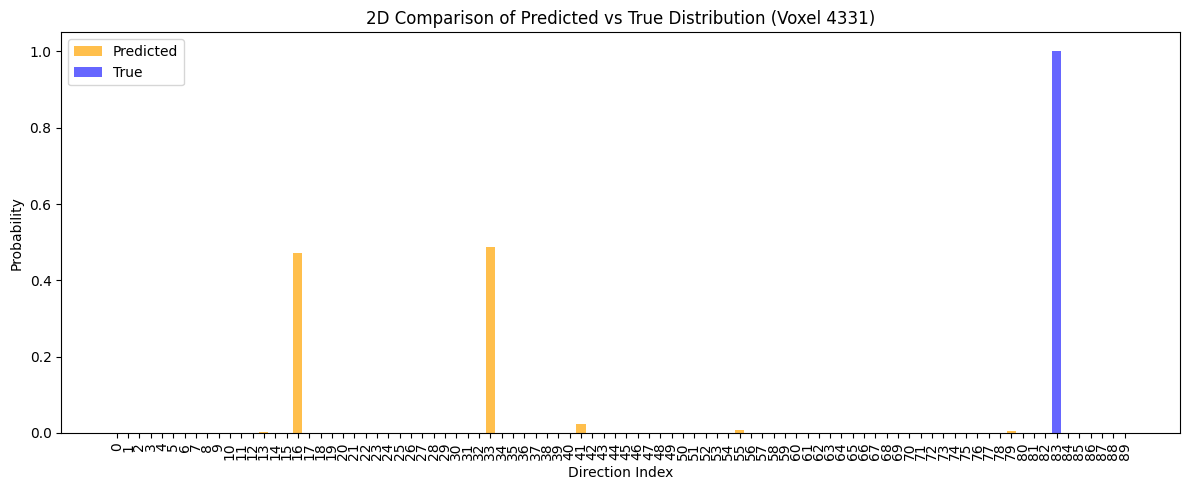

33
Error  Angle in radians: 1.934231842257492
Error Angle in degrees: 110.8233211611683


In [85]:
##### import numpy as np
import matplotlib.pyplot as plt

# Load data
probs = np.load("output_probabilities.npy")      # shape: [N, 270]
#print(len())
# Choose voxel
voxel_idx = 4331

voxel_probs = probs[voxel_idx]  # [270]
true_label = labels[voxel_idx]  # scalar

# Reference one-hot distribution
ref_probs = np.zeros_like(voxel_probs)

ref_probs[true_label] = 1.0

# Plot 2D bar chart of predicted vs reference probabilities
plt.figure(figsize=(12, 5))
x = np.arange(len(voxel_probs))

plt.bar(x, voxel_probs, label="Predicted", alpha=0.7, color='orange')
plt.bar(x, ref_probs, label="True", alpha=0.6, color='blue')
plt.xticks(ticks=x, labels=x, rotation=90)
plt.xlabel("Direction Index")
plt.ylabel("Probability")
plt.title(f"2D Comparison of Predicted vs True Distribution (Voxel {voxel_idx})")
plt.legend()
plt.tight_layout()
plt.savefig(f"voxel_{voxel_idx}_2d_prob_comparison.png")
plt.show()



voxel0_cuda = probs[voxel_idx]
voxel0_cpu = voxel0_cuda
voxel0_cpu_numpy = voxel0_cpu
#print(len(voxel0_cpu_numpy))
voxel0_maxdir = np.argmax(voxel0_cpu_numpy) #print(np.argmax(voxel_probs))
print(voxel0_maxdir)

angle_rad=calculate_angular_error(X[voxel_idx][voxel0_maxdir][2:], Y[voxel_idx])
angle_deg = np.degrees(angle_rad)

print(f"Error  Angle in radians: {angle_rad}")
print(f"Error Angle in degrees: {angle_deg}")

#print("true_label",true_label,probs[true_label])

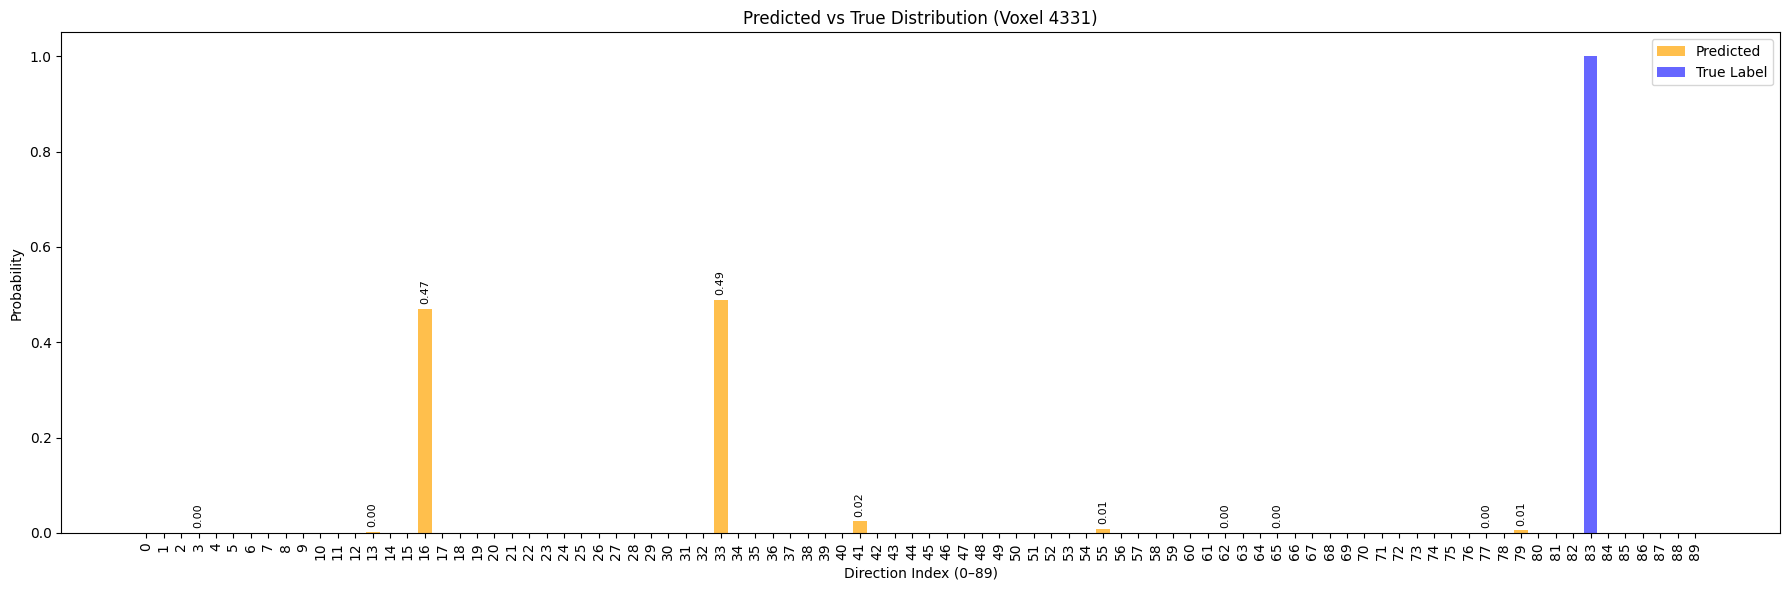

In [86]:
plt.figure(figsize=(18, 6))
bars = plt.bar(x, voxel_probs, label="Predicted", alpha=0.7, color='orange')
plt.bar(x, ref_probs, label="True Label", alpha=0.6, color='blue')

plt.xticks(ticks=x, labels=x, rotation=90)
plt.xlabel("Direction Index (0–89)")
plt.ylabel("Probability")
plt.title(f"Predicted vs True Distribution (Voxel {voxel_idx})")
plt.legend()

top_10_indices = np.argsort(voxel_probs)[-10:][::-1]  # Indices of top 10
for i in top_10_indices:
    plt.text(i, voxel_probs[i] + 0.01, f"{voxel_probs[i]:.2f}", 
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig(f"voxel_{voxel_idx}_2d_prob_comparison_top10.png", dpi=300)
plt.show()

In [131]:
voxel_idx

33395

In [65]:
angle_error_rads =[]
angle_error_degs =[]
for i in range(len(Y)-1) :
    voxel_probs = probs[i]  # [270]
    true_label = labels[i]
    voxel_probs_max = np.argmax(voxel_probs)
    angle_rad=calculate_angular_error(X[i][voxel_probs_max][2:], Y[i])
    angle_deg = np.degrees(angle_rad)
    angle_error_rads.append(angle_rad)
    angle_error_degs.append(angle_deg)

print(sum(angle_error_rads)/len(angle_error_rads))
print(sum(angle_error_degs)/len(angle_error_degs))

IndexError: index 6679 is out of bounds for axis 0 with size 6679

In [87]:
angle_errors = []
for i in range(len(probs)):
    pred_vec = X[i][np.argmax(probs[i])][2:]
    true_vec = Y[i]

    # Angular error
    angle_rad = calculate_angular_error(pred_vec, true_vec)
    angle_deg = np.degrees(angle_rad)

    # Adjusted for symmetry
    sym_angle_deg = min(angle_deg, 180 - angle_deg)

    angle_errors.append(sym_angle_deg)

print(f"Mean angular error with symmetry mitigation: {np.mean(angle_errors):.2f}°")

Mean angular error with symmetry mitigation: 54.11°


In [67]:
# Convert to NumPy array for easier indexing
angle_error_degs = np.array(angle_error_degs)

# Get indices of top 10 angular errors
top_10_error_indices = np.argsort(angle_error_degs)[-100:][::-1]

print("Top 10 voxel indices with highest angular error:")
print(top_10_error_indices)

print("\nCorresponding angular errors (degrees):")
for idx in top_10_error_indices:
    print(f"Voxel {idx}: {angle_error_degs[idx]:.2f}°")

Top 10 voxel indices with highest angular error:
[  90  140 2573 3141 4783 5750 3250 3561 3801 2813 4125 4168 4674  538
 1971 2918 4231 4624   27  193 1225 1930 1778 6395 3702 2365 6603 1183
 5340 3638 3931  934 3325 3971 2085 3137 3502 1824 6460 5850 6121 6401
 4988 2129 4364  174 6095 5629 1413  286 3692 5120 3111 3139 5793 4476
 3938 5101 5849 1115 4398 1338  476 3771 2158 5257 5091 3406 1806 3650
 3554 6672 3741  329 4017 5873 2402 5527 3337 1567 1547 3071 5282 4983
 1481 6124 1877 3880  403 4431 3359 1560  710 2099  565 5605 1705 6356
 3438 5029]

Corresponding angular errors (degrees):
Voxel 90: 179.82°
Voxel 140: 178.18°
Voxel 2573: 178.13°
Voxel 3141: 178.08°
Voxel 4783: 177.67°
Voxel 5750: 177.43°
Voxel 3250: 177.10°
Voxel 3561: 177.09°
Voxel 3801: 176.83°
Voxel 2813: 176.76°
Voxel 4125: 176.75°
Voxel 4168: 176.61°
Voxel 4674: 176.36°
Voxel 538: 175.98°
Voxel 1971: 175.94°
Voxel 2918: 175.89°
Voxel 4231: 175.82°
Voxel 4624: 175.81°
Voxel 27: 175.67°
Voxel 193: 175.62°
Voxel 12

In [50]:
for idx in top_10_error_indices:
    pred_vec = X[idx][np.argmax(probs[idx])][2:]
    true_vec = Y[idx]
    dot_product = np.dot(pred_vec, true_vec)
    print(f"Voxel {idx}: dot(pred, true) = {dot_product:.3f}")

Voxel 4331: dot(pred, true) = -1.000
Voxel 32739: dot(pred, true) = -1.000
Voxel 13015: dot(pred, true) = -1.000
Voxel 16321: dot(pred, true) = -1.000
Voxel 5632: dot(pred, true) = -1.000
Voxel 24752: dot(pred, true) = -1.000
Voxel 29392: dot(pred, true) = -1.000
Voxel 20679: dot(pred, true) = -1.000
Voxel 22740: dot(pred, true) = -1.000
Voxel 8659: dot(pred, true) = -1.000
Voxel 11773: dot(pred, true) = -1.000
Voxel 22779: dot(pred, true) = -1.000
Voxel 210: dot(pred, true) = -1.000
Voxel 16280: dot(pred, true) = -1.000
Voxel 16672: dot(pred, true) = -1.000
Voxel 20383: dot(pred, true) = -1.000
Voxel 26800: dot(pred, true) = -1.000
Voxel 3945: dot(pred, true) = -1.000
Voxel 13180: dot(pred, true) = -1.000
Voxel 1085: dot(pred, true) = -1.000
Voxel 7516: dot(pred, true) = -1.000
Voxel 13727: dot(pred, true) = -1.000
Voxel 3923: dot(pred, true) = -1.000
Voxel 23370: dot(pred, true) = -1.000
Voxel 7173: dot(pred, true) = -1.000
Voxel 8131: dot(pred, true) = -1.000
Voxel 32212: dot(pred, 

In [132]:
print(voxel0_maxdir)

12


In [159]:
np.mean(pred_indices == labels)


0.5182057731464846

In [133]:
probs[31]

array([1.7288114e-06, 1.8965043e-11, 2.6953580e-11, 5.3565714e-06,
       4.7920121e-13, 3.3743492e-09, 9.7307600e-13, 4.0768390e-03,
       9.2163708e-07, 8.9573460e-11, 2.0321012e-10, 1.5550486e-02,
       1.7880068e-12, 1.5727316e-03, 1.1582313e-11, 2.5628141e-12,
       3.8469871e-06, 2.1234119e-12, 9.9577573e-09, 2.2596588e-11,
       4.4964192e-09, 3.1825142e-13, 1.9496937e-12, 2.0122869e-11,
       7.3031137e-13, 3.7281295e-10, 1.1517245e-06, 2.0834539e-12,
       3.8459925e-12, 1.0672569e-11, 3.2217046e-10, 3.1988821e-11,
       5.8076965e-10, 1.0541639e-06, 1.5578917e-07, 6.2580043e-01,
       9.2606159e-11, 1.0556565e-07, 1.1147869e-11, 1.4018289e-11,
       3.2204389e-10, 4.2722372e-09, 9.8486941e-13, 3.0389170e-11,
       5.6817520e-09, 5.7184497e-11, 3.8900367e-12, 9.3820221e-12,
       4.1837080e-07, 8.5889873e-09, 8.7725044e-12, 2.2081800e-12,
       1.9889596e-12, 1.2874551e-12, 3.4188101e-09, 3.8571285e-05,
       7.0616296e-10, 1.6718079e-12, 2.4672131e-11, 1.1071595e

In [134]:
Y[voxel_idx]

array([ 0.184153  ,  0.8028291 , -0.56705654], dtype=float32)

In [135]:
ref_probs.shape

(90,)

In [136]:
X[voxel_idx][voxel0_maxdir][2:]

array([ 0.1314509 ,  0.9044206 , -0.40588674], dtype=float32)

In [137]:
Y[voxel_idx]

array([ 0.184153  ,  0.8028291 , -0.56705654], dtype=float32)

In [138]:
len(probs)

33396

In [139]:
angular_errors_deg = []

for i in range(len(X)):
    # Get predicted direction index for this voxel
    pred_idx = np.argmax(prob_distributions[i])  # [270]

    # Extract predicted b-vector from input X
    pred_vec = X[i][pred_idx][2:]  # [bx, by, bz]

    # Get ground truth vector
    true_vec = Y[i]  # [x, y, z]

    # Compute angular error
    angle_rad = calculate_angular_error(pred_vec, true_vec)
    angle_deg = np.degrees(angle_rad)

    angular_errors_deg.append(angle_deg)

In [140]:
len(angular_errors_deg)

33396

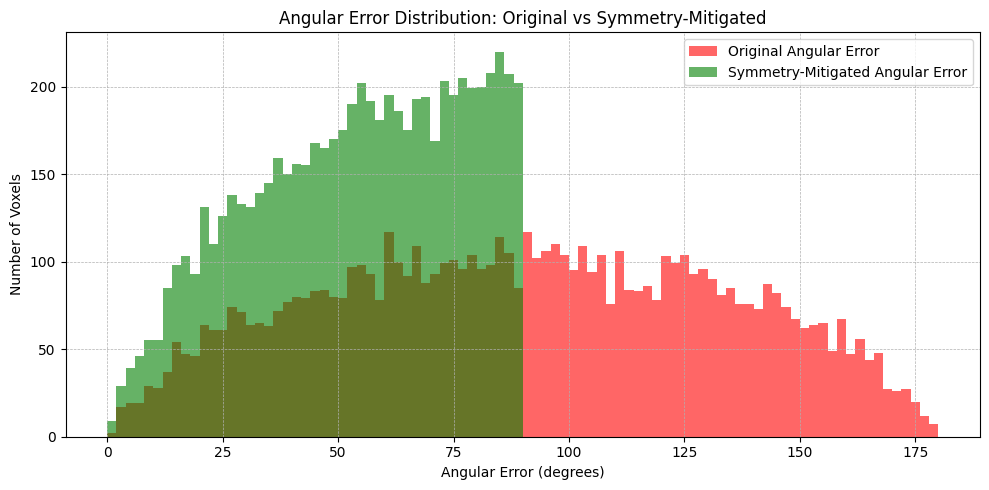

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Compute angular errors and symmetry-mitigated errors
angle_errors_deg = []
sym_angle_errors_deg = []

for i in range(len(probs)):
    pred_vec = X[i][np.argmax(probs[i])][2:]
    true_vec = Y[i]

    angle_rad = calculate_angular_error(pred_vec, true_vec)
    angle_deg = np.degrees(angle_rad)
    
    angle_errors_deg.append(angle_deg)
    sym_angle_errors_deg.append(min(angle_deg, 180 - angle_deg))  # adjusted for antipodal symmetry

angle_errors_deg = np.array(angle_errors_deg)
sym_angle_errors_deg = np.array(sym_angle_errors_deg)

# Plot histograms
plt.figure(figsize=(10, 5))
bins = np.linspace(0, 180, 91)  # every 2 degrees

plt.hist(angle_errors_deg, bins=bins, alpha=0.6, label='Original Angular Error', color='red')
plt.hist(sym_angle_errors_deg, bins=bins, alpha=0.6, label='Symmetry-Mitigated Angular Error', color='green')

plt.xlabel("Angular Error (degrees)")
plt.ylabel("Number of Voxels")
plt.title("Angular Error Distribution: Original vs Symmetry-Mitigated")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("angular_error_distribution_comparison.png", dpi=300)
plt.show()


In [44]:
X[0][np.argmax(probs[0])][2:],Y[0]

(array([0.5634436, 0.6375738, 0.5253865], dtype=float32),
 array([-0.61389345,  0.66524196, -0.4249564 ], dtype=float32))

In [50]:
pred_vec, true_vec

(array([ 0.17786075,  0.6288659 , -0.75689715], dtype=float32),
 array([ 0.184153  ,  0.8028291 , -0.56705654], dtype=float32))

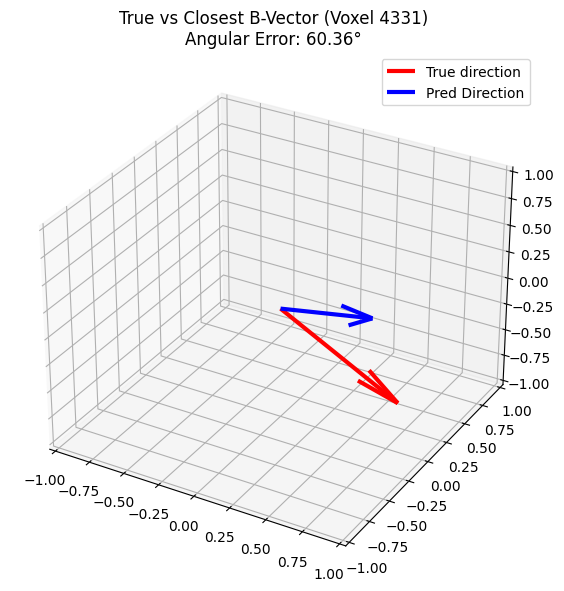

In [80]:
# voxel_idx = 0

# # Extract bvecs and normalize
# bvecs = X[voxel_idx, :, 2:5]
# print(len(bvecs))
# bvecs = np.append(bvecs,-bvecs, axis=0)
# print(len(bvecs))
# bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# # Extract true direction and normalize
# true_dir = Y[voxel_idx]
# true_dir = true_dir / np.linalg.norm(true_dir)

# # Cosine similarity with all bvecs
# cos_sim = bvecs @ true_dir
# best_idx = np.argmax(cos_sim)
# best_bvec = bvecs[best_idx]

# # Angular error
# angle_rad = np.arccos(np.clip(np.dot(best_bvec, true_dir), -1.0, 1.0))
# angle_deg = np.degrees(angle_rad)

# # Print results
# print(f"Voxel {voxel_idx}: Best matching bvec index = {best_idx}")
# print(f"Angular error = {angle_deg:.2f}°")

# # Plot true direction and best bvec
i = 4331
pred_vec = X[i][np.argmax(probs[i])][2:]
true_vec = Y[i]
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

# ax.quiver(0, 0, 0, true_dir[0], true_dir[1], true_dir[2],
#           color='red', linewidth=3, label='True direction')
# ax.quiver(0, 0, 0, best_bvec[0], best_bvec[1], best_bvec[2],
#           color='blue', linewidth=3, label='Closest bvec')

ax.quiver(0, 0, 0, true_vec[0], true_vec[1], true_vec[2],
          color='red', linewidth=3, label='True direction')
ax.quiver(0, 0, 0, pred_vec[0], pred_vec[1], pred_vec[2],color='blue', linewidth=3, label='Pred Direction')
 
error = np.degrees(calculate_angular_error(true_vec, pred_vec))
ax.set_title(f"True vs Closest B-Vector (Voxel {voxel_idx})\nAngular Error: {error:.2f}°")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.legend()
plt.tight_layout()
plt.show()